<a href="https://colab.research.google.com/github/Shourya-Chambial/ISAA_DA1/blob/main/deepfake_detector_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gdown
import sys 
import os
import glob
import imghdr
import numpy as np
from math import ceil
from PIL import Image
from keras.preprocessing import image
from keras.applications.xception import preprocess_input
from keras.models import load_model
from keras.losses import categorical_crossentropy
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
# for data/image preparation
classes = ["real", "fake"] # label 0: real, label 1: fake
num_classes = 2

def load_images_and_prepare_labels(image_folder_path):
    images_paths, labels = [], []
    for class_name in os.listdir(image_folder_path):
      class_root = os.path.join(image_folder_path, class_name)
      class_id = classes.index(class_name)
      for path in os.listdir(class_root):
          path = os.path.join(class_root, path)
          if imghdr.what(path) is None:
              # this is not an image file
              continue
          images_paths.append(path)
          labels.append(class_id)
    # convert ot numpy array
    images_paths = np.array(images_paths)
    return images_paths, labels

In [3]:
# for model classification
def load_image_as_np_arr(img_path): # load img as np array
    img = image.load_img(img_path, target_size=(128, 128))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def load_image_as_tensor(img_path): # load img as tensor
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (128, 128))
    img = preprocess_input(img)
    img = img[None, ...]
    return img

def classify(model, x): # x is a np array, use model to predict the label of x
    pred = model.predict(x)[0]
    pred_label = np.argmax(pred)
    return pred_label

In [4]:
# for image visualization
def denormalize_img(x):
    # x is the image represented in numpy array
    x = (x+1)*127.5
    x /= 255
    # x = np.clip(x, 0, 255)
    return x

# visualize normal & perturbed image side by side
# also display their prediction labels
def display_image_pair(x, adv_x, actual_label, pred_label):
    # x and adv_x are numpy arrays
    x = x.squeeze()
    x = denormalize_img(x)
    adv_x = adv_x.squeeze()
    adv_x = denormalize_img(adv_x)

    # both x and adv_x are numpy array
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(x); ax[0].axis("off")
    ax[0].set_title("Original image", fontsize=15)
    ax[0].text(0.5,-0.13, "Actual class: {}".format(classes[actual_label]), 
                size=12, ha="center", transform=ax[0].transAxes)
    
    ax[1].imshow(adv_x); ax[1].axis("off")
    ax[1].set_title("Perturbed image", fontsize=15)
    ax[1].text(1.8,-0.13, "Predicted class: {}".format(classes[pred_label]), 
                size=12, ha="center", transform=ax[0].transAxes)
    
    ax[2].axis("off")
    
    plt.show()

In [5]:
# for model performance evaluation
def evaluate_model_performance(img_paths, labels, attack_fn=None, display_num=3):
    # positive: fake, negative: real
    true_positive = 0   # predict fake as fake
    false_positive = 0  # predict fake as real
    true_negative = 0   # predict real as real
    false_negative = 0  # predict real as fake

    display_i = 0  # number of display sample

    for i in range(len(img_paths)):
      img_path = img_paths[i]
      actual_label = labels[i]

      # load an input image
      x = load_image_as_np_arr(img_path)

      # predict the label of image
      if attack_fn is None:
          pred_label = classify(final_model, x)
      else:
          if attack_fn == "fgsm":
            adv_x = fgsm(img_path, actual_label)
          elif attack_fn == "fgvm":
            adv_x = fgvm(img_path, actual_label)
          elif attack_fn == "simple one pixel":
            adv_x = simple_one_pixel_attack(x)
          elif attack_fn == "one pixel with differetial evolution":
            adv_x = one_pixel_attack(x, actual_label, final_model, maxiter=20)
          else:
            raise Exception("Attack method not supported")
            
          pred_label = classify(final_model, adv_x)
          # selectively display a few fake images result
          display_imgs = ["111.jpg", "251.jpg", "698.jpg"]
          if actual_label == 1 and os.path.basename(img_path) in display_imgs:
            display_image_pair(x, adv_x, actual_label, pred_label)

      # compare prediction with ground truth
      # label 0: real, label 1: fake
      if actual_label == 0:
        if pred_label == 0:
          true_negative += 1
        else:
          false_negative += 1
      else:
        if pred_label == 1:
          true_positive += 1
        else:
          false_positive += 1

    return true_positive, false_positive, true_negative, false_negative

In [6]:
# download testing images (containing cropped CelebA images and the researchers' DCGAN images)
!gdown https://drive.google.com/uc?id=1HrkXC4fjVojzC15d-i1lNtad8dnzo4oE

!unzip -q /content/testing_images.zip
!rm -r /content/testing_images.zip

!mv /content/content/testing_images /content/
!rm -r /content/content

Downloading...
From: https://drive.google.com/uc?id=1HrkXC4fjVojzC15d-i1lNtad8dnzo4oE
To: /content/testing_images.zip
100% 1.50M/1.50M [00:00<00:00, 47.6MB/s]


In [7]:
# load the real and fake images in testing datasets
all_images, labels = load_images_and_prepare_labels("/content/testing_images")

In [8]:

# index 0 - 199 are fake images, select 64 of them
# index 200 - 399 are real images, select 64 of them
fake_images = all_images[:64]
real_images = all_images[200:264]
print(len(fake_images), len(real_images))

64 64


In [9]:
# download the fake images that we generated
!gdown https://drive.google.com/uc?id=1l_rBcS0gIWEnSQQN23a-DQciSsk4JR6i

!unzip -q /content/dark_haiya_deepfake.zip
!rm -r /content/dark_haiya_deepfake.zip

Downloading...
From: https://drive.google.com/uc?id=1l_rBcS0gIWEnSQQN23a-DQciSsk4JR6i
To: /content/dark_haiya_deepfake.zip
100% 231k/231k [00:00<00:00, 67.3MB/s]


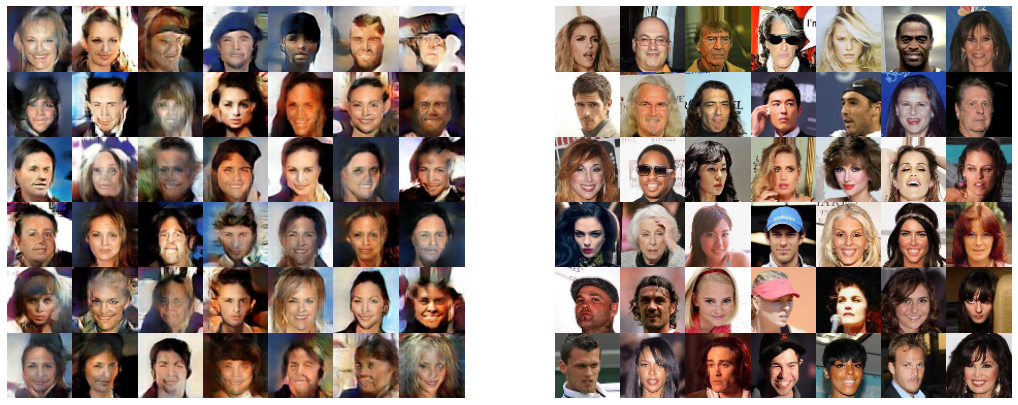

In [10]:
# display our own deepfakes and researchers' deepfakes side by side
our_deepfakes = glob.glob("/content/fake/*")
our_deepfakes = our_deepfakes[:64]

fig = plt.figure(figsize=(18, 18))
our_deepfake_grid = ImageGrid(fig, 121,
                          nrows_ncols=(6, 7),
                          axes_pad=0)

fake_img_grid = ImageGrid(fig, 122,  # similar to subplot(111)
                          nrows_ncols=(6, 7),  # creates 2x2 grid of axes
                          axes_pad=0,  # pad between axes in inch.
                          )

for ax, img_path in zip(our_deepfake_grid, our_deepfakes):
    img = Image.open(img_path)
    # Iterating over the grid returns the Axes.
    ax.imshow(img)
    ax.axis("off")

for ax, img_path in zip(fake_img_grid, fake_images):
    img = image.load_img(img_path, target_size=(64, 64))
    img = image.img_to_array(img)
    img /= 255
    # Iterating over the grid returns the Axes.
    ax.imshow(img)
    ax.axis("off")

plt.show()

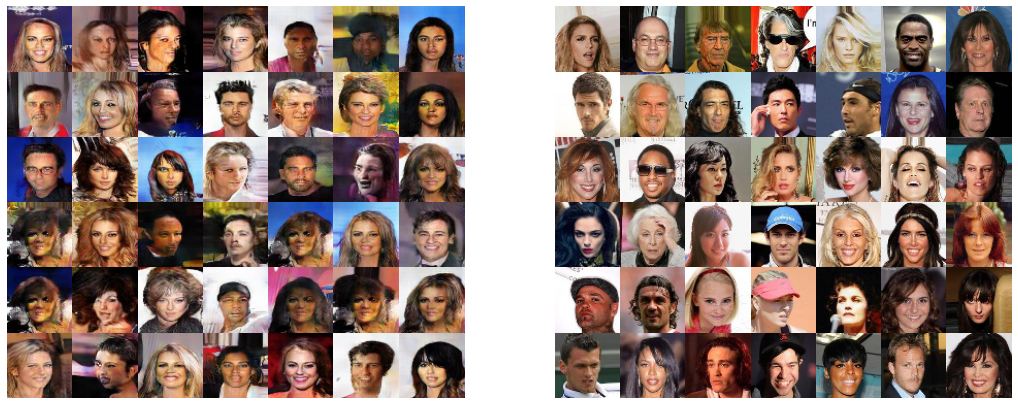

In [11]:
# display cropped CelebA images and DCGAN images side by side
# left hand side: cropped CelebA images; right hand side: DCGAN images
fig = plt.figure(figsize=(18, 18))
real_img_grid = ImageGrid(fig, 121,
                          nrows_ncols=(6, 7),
                          axes_pad=0)

fake_img_grid = ImageGrid(fig, 122,  # similar to subplot(111)
                          nrows_ncols=(6, 7),  # creates 2x2 grid of axes
                          axes_pad=0,  # pad between axes in inch.
                          )

for ax, img_path in zip(real_img_grid, real_images):
    img = image.load_img(img_path, target_size=(64, 64))
    img = image.img_to_array(img)
    img /= 255
    # Iterating over the grid returns the Axes.
    ax.imshow(img)
    ax.axis("off")

for ax, img_path in zip(fake_img_grid, fake_images):
    img = image.load_img(img_path, target_size=(64, 64))
    img = image.img_to_array(img)
    img /= 255
    # Iterating over the grid returns the Axes.
    ax.imshow(img)
    ax.axis("off")

plt.show()


In [12]:
# download model
!gdown https://drive.google.com/uc?id=1UtDvRIVRWUvCMVZLDGIJk707-DGJ1lW1

Downloading...
From: https://drive.google.com/uc?id=1UtDvRIVRWUvCMVZLDGIJk707-DGJ1lW1
To: /content/model_fine_final.h5
276MB [00:02, 108MB/s]


In [13]:
# load model
model_path = "/content/model_fine_final.h5"
final_model = load_model(model_path)

In [14]:
tp, fp, tn, fn = evaluate_model_performance(all_images, labels)
print("Total images used: %d" % len(all_images))
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)

Total images used: 400
Predict fake as fake: 185
Predict fake as real: 15
Predict real as real: 199
Predict real as fake: 1


In [15]:
# generate adversarial image using FGVM technique
def fgvm(img_path, input_label):
    x = load_image_as_tensor(img_path)
    label = tf.one_hot(input_label, num_classes)
    label = tf.reshape(label, (1, num_classes))

    with tf.GradientTape() as tape:
      tape.watch(x)
      prediction = final_model(x)
      loss = categorical_crossentropy(label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, x)

    adv_x = x + gradient

    # convert to numpy
    adv_x = adv_x.numpy()

    return adv_x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


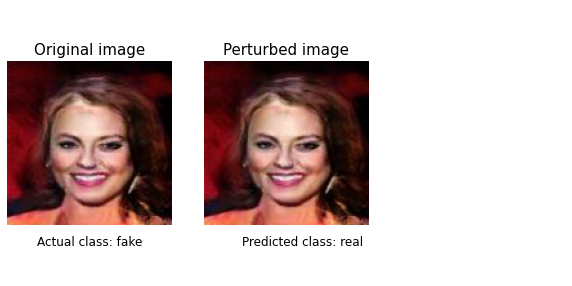

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


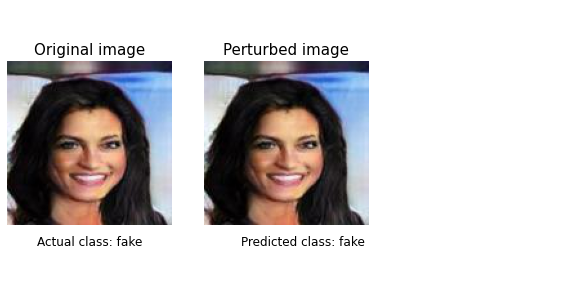

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


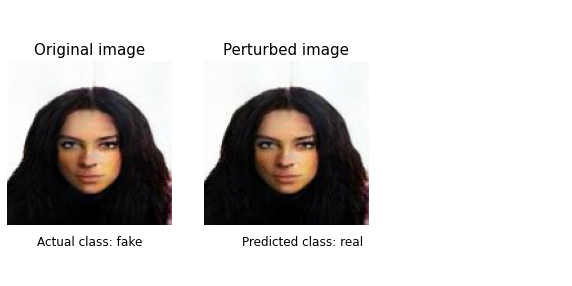

In [16]:
tp, fp, tn, fn = evaluate_model_performance(all_images, labels, attack_fn="fgvm")

In [17]:
print("Total images used: %d" % len(all_images))
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)

Total images used: 400
Predict fake as fake: 139
Predict fake as real: 61
Predict real as real: 197
Predict real as fake: 3


In [18]:
# Clone the relevant Github
!git clone https://github.com/Hyperparticle/one-pixel-attack-keras.git

Cloning into 'one-pixel-attack-keras'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 356 (delta 3), reused 1 (delta 0), pack-reused 346
Receiving objects: 100% (356/356), 44.57 MiB | 32.09 MiB/s, done.
Resolving deltas: 100% (204/204), done.


In [19]:
%cd /content/one-pixel-attack-keras

/content/one-pixel-attack-keras


In [20]:
# import useful functions from the git
from differential_evolution import differential_evolution
import helper

In [21]:
# change the centre pixel to yellow
pixel= np.array([64, 64, 255, 255, 0])
def simple_one_pixel_attack(x):
    attack_image = helper.perturb_image(pixel, x)
    return attack_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


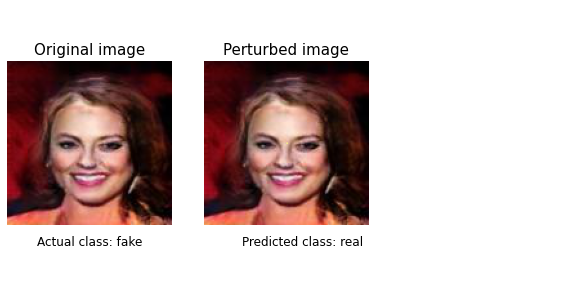

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


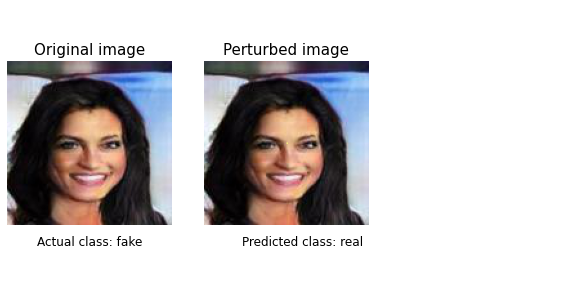

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


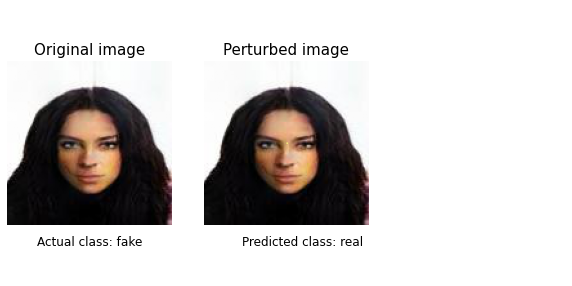

In [22]:
tp, fp, tn, fn = evaluate_model_performance(all_images, labels, attack_fn="simple one pixel")

In [23]:
print("Total images used: %d" % len(all_images))
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)

Total images used: 400
Predict fake as fake: 0
Predict fake as real: 200
Predict real as real: 200
Predict real as fake: 0
